In [49]:
!pip install mibian

  Created wheel for mibian: filename=mibian-0.1.3-py3-none-any.whl size=4039 sha256=817f616bf1448effae3675c1139f109a341fad3532228cff4cfaddbb0024d7ef
  Stored in directory: c:\users\tabit\appdata\local\pip\cache\wheels\bb\8e\88\9401e806f2eaf5d2f4e775e598c27d7cc09bfb06998d075093
Successfully built mibian


In [111]:
import numpy as np 
import pandas as pd
import seaborn as sns   
import mibian
import time
import datetime
from matplotlib import pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
    
from sklearn.svm import SVC 

# Train/Test Preparation

In [365]:
def process_data(df, symbol, sector, call):
    # we can choose to do either sectors or a single stock
    symbol_df = df[df.Sector==symbol] if sector else df[df.Symbol==symbol] 
    symbol_df = symbol_df[symbol_df['Call'] == 1] if call else symbol_df[symbol_df['Call'] == 0]
    symbol_df.columns = symbol_df.columns.str.strip()

    symbol_df = symbol_df.replace({'In the Money': {'True':1, 'False':0}})
    symbol_df = symbol_df.replace({'In the Money': {True:1, False:0}})
    symbol_df = symbol_df.replace({'Call': {True:1,False:0}})

    # Columns to drop for our input feature vector
    columns = ['Symbol','Expiration Date', 'Sector', 'Industry', 'Record Time', 'Profit', 'Call']
    symbol_df = symbol_df.drop(columns=columns)
    
    # resampling code
    failed_len = len(symbol_df[symbol_df['Success'] == 0])
    
    count = len(symbol_df[symbol_df['Success'] == 1])
    if count < failed_len:
        count_failed = count * 3 if failed_len > count * 3 else count * 2
        count_failed = count_failed if failed_len > count_failed else count
    else:
        count_failed = failed_len
    
    failed_df = symbol_df.loc[symbol_df['Success'] == 0].sample(n=count_failed,random_state=42)
    success_df = symbol_df.loc[symbol_df['Success'] == 1]
    
    return pd.concat([failed_df, success_df])

In [612]:
# Scraped yahoo data
options_data_3_11_df = pd.read_csv('../yahooData/results/finalData_3-11.csv', delimiter=',')
options_data_3_18_df = pd.read_csv('../yahooData/results/finalData_3-18.csv', delimiter=',')
options_data_3_25_df = pd.read_csv('../yahooData/results/finalData_3-25.csv', delimiter=',')
options_data_4_01_df = pd.read_csv('../yahooData/results/finalData_4-01.csv', delimiter=',')
options_data_4_08_df = pd.read_csv('../yahooData/results/finalData_4-08.csv', delimiter=',')
options_data_4_15_df = pd.read_csv('../yahooData/results/finalData_4-15.csv', delimiter=',')
options_data_4_22_df = pd.read_csv('../yahooData/results/finalData_4-22.csv', delimiter=',')

options_data_3_11_df_c = process_data(options_data_3_11_df, 'Technology', True, True)
options_data_3_18_df_c = process_data(options_data_3_18_df, 'Technology', True, True)
options_data_3_25_df_c = process_data(options_data_3_25_df, 'Technology', True, True)
options_data_4_01_df_c = process_data(options_data_4_01_df, 'Technology', True, True)
options_data_4_08_df_c = process_data(options_data_4_08_df, 'Technology', True, True)
options_data_4_15_df_c = process_data(options_data_4_15_df, 'Technology', True, True)
options_data_4_22_df_c = process_data(options_data_4_22_df, 'Technology', True, True)

calls_df = pd.concat([options_data_3_11_df_c, options_data_3_18_df_c, options_data_3_25_df_c, options_data_4_01_df_c, options_data_4_08_df_c])
options7call_df = pd.concat([options_data_4_15_df_c, options_data_4_22_df_c])

options_data_3_11_df_p = process_data(options_data_3_11_df, 'Technology', True, False)
options_data_3_18_df_p = process_data(options_data_3_18_df, 'Technology', True, False)
options_data_3_25_df_p = process_data(options_data_3_25_df, 'Technology', True, False)
options_data_4_01_df_p = process_data(options_data_4_01_df, 'Technology', True, False)
options_data_4_08_df_p = process_data(options_data_4_08_df, 'Technology', True, False)
options_data_4_15_df_p = process_data(options_data_4_15_df, 'Technology', True, False)
options_data_4_22_df_p = process_data(options_data_4_22_df, 'Technology', True, False)

puts_df = pd.concat([options_data_3_11_df_p, options_data_3_18_df_p, options_data_3_25_df_p, options_data_4_01_df_p, options_data_4_08_df_p])
options7puts_df = pd.concat([options_data_4_15_df_p, options_data_4_22_df_p])

D:\Program_Files\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [613]:
def run_log_reg_model(features, train_df, test_df, scaled=False, call=True, profit=False):
    X_train = train_df
    y_train = np.ravel(X_train[['Success']])
    X_train = X_train[features]

    # feature scaling
    scaler = StandardScaler()
    scaler.fit(X_train)

    # scaled data if we choose to via the parameters
    X_train_scaled = scaler.transform(X_train) if scaled else X_train

    X_test = test_df
    y_test = np.ravel(X_test[['Success']])
    X_test = X_test[features]
    
    X_test_scaled = scaler.transform(X_test) if scaled else X_test
    
    log_reg_model = LogisticRegression(penalty="l2", max_iter=10000000)
    log_reg_model.fit(X_train_scaled, y_train)
    y = log_reg_model.predict(X_test_scaled)
    
    score = log_reg_model.score(X_test_scaled, y_test)
    prec = list(precision_recall_fscore_support(y_test, y, average='macro'))
    prec[-1] = score
    features_df = pd.DataFrame({"Feature": features, "Abs of Coefficients":abs(log_reg_model.coef_[0])})
    
    if profit:
        # Add the profit columns
        X_test = test_df.reset_index(drop=True).drop('Success', axis=1)
        X_profitability = pd.concat([X_test, pd.DataFrame(y)], axis=1, ignore_index=True)
        X_profitability.columns = test_df.columns
        X_profitability["Profit"] = X_profitability["Final Price"] - X_profitability["Breakeven Price"] if call else X_profitability["Breakeven Price"] - X_profitability["Final Price"]
        # Uncomment to plot the profit for each option against any of the columns
        # sns.lineplot(data=X_profitability, x="Days to Expire", y="Profit", hue="Success")
        # plt.show()
        profit =  X_profitability.loc[X_profitability['Success'] == 1].Profit.sum()
        prec.append(profit)
        profit_percent =  100 * profit / X_profitability.loc[X_profitability['Success'] == 1].Mark.sum()
        prec.append(profit_percent)
        # Display the metrics
        display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy", "Profitability", "Profit Percent"], "Results:":prec}))
    else:    
        # Display the metrics
        display(pd.DataFrame({"Metric:": ["Precision", "Recall", "F1", "Accuracy"], "Results:":prec}))
    
    return features_df

# Visualizing Calls Features

,Metric:,Results:
0,Precision,0.708546
1,Recall,0.777344
2,F1,0.697783
3,Accuracy,0.720703


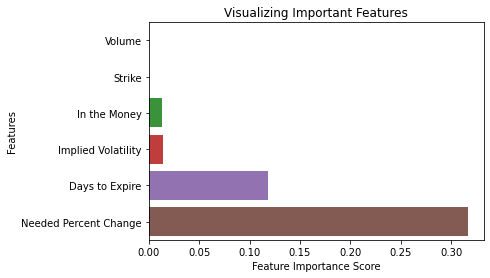

,Metric:,Results:
0,Precision,0.716826
1,Recall,0.788411
2,F1,0.706407
3,Accuracy,0.728516


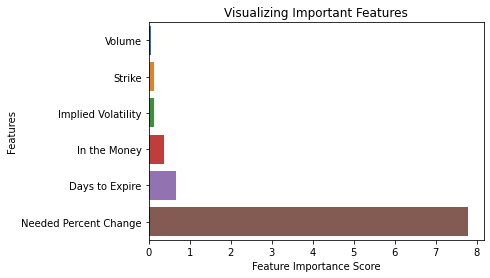

In [614]:
feature_imp = run_log_reg_model(calls_df.columns.drop(["Final Price","Success", "Mark", "Breakeven Price", "Current Price"]), calls_df, options7call_df, False, True)

# Creating a bar plot
sns.barplot(y="Feature", x="Abs of Coefficients", data=feature_imp, orient="h", order=feature_imp.sort_values('Abs of Coefficients').Feature)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

feature_imp = run_log_reg_model(calls_df.columns.drop(["Final Price","Success", "Mark", "Breakeven Price", "Current Price"]), calls_df, options7call_df, True, True)

# Creating a bar plot
sns.barplot(y="Feature", x="Abs of Coefficients", data=feature_imp, orient="h", order=feature_imp.sort_values('Abs of Coefficients').Feature)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Visualizing Puts Features

,Metric:,Results:
0,Precision,0.790320
1,Recall,0.723819
2,F1,0.700430
3,Accuracy,0.715259


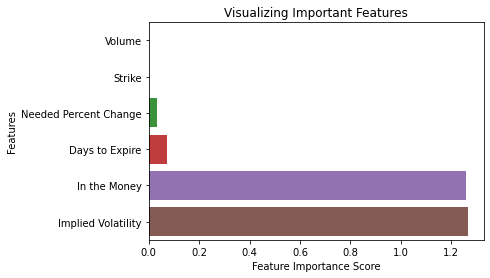

,Metric:,Results:
0,Precision,0.791831
1,Recall,0.726851
2,F1,0.704198
3,Accuracy,0.718403


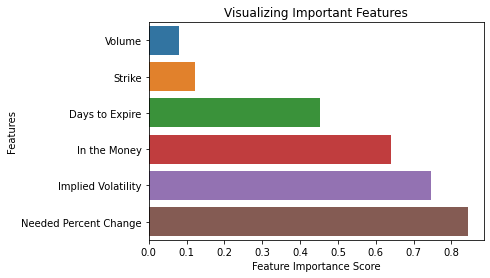

In [615]:
feature_imp = run_log_reg_model(puts_df.columns.drop(["Final Price","Success", "Mark", "Breakeven Price", "Current Price"]), puts_df, options7puts_df)

# Creating a bar plot
sns.barplot(y="Feature", x="Abs of Coefficients", data=feature_imp, orient="h", order=feature_imp.sort_values('Abs of Coefficients').Feature)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

feature_imp = run_log_reg_model(puts_df.columns.drop(["Final Price","Success", "Mark", "Breakeven Price", "Current Price"]), puts_df, options7puts_df, True)

# Creating a bar plot
sns.barplot(y="Feature", x="Abs of Coefficients", data=feature_imp, orient="h", order=feature_imp.sort_values('Abs of Coefficients').Feature)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# LR Calls Models

In [616]:
run_log_reg_model(['Implied Volatility', 'Days to Expire', 'Needed Percent Change', 'In the Money'], calls_df, options7call_df, False, True, True)

,Metric:,Results:
0,Precision,0.718070
1,Recall,0.790039
2,F1,0.707907
3,Accuracy,0.729980
4,Profitability,-7147.700000
5,Profit Percent,-14.690891


,Feature,Abs of Coefficients
0,Implied Volatility,0.067511
1,Days to Expire,0.112280
2,Needed Percent Change,0.259321
3,In the Money,0.620937


In [617]:
run_log_reg_model(['Needed Percent Change', 'Days to Expire'], calls_df, options7call_df, False, True, True)

,Metric:,Results:
0,Precision,0.709826
1,Recall,0.779297
2,F1,0.697598
3,Accuracy,0.719727
4,Profitability,-7591.735000
5,Profit Percent,-15.658013


,Feature,Abs of Coefficients
0,Needed Percent Change,0.315428
1,Days to Expire,0.116623


In [618]:
run_log_reg_model(['Needed Percent Change', 'Implied Volatility'], calls_df, options7call_df, False, True, True)

,Metric:,Results:
0,Precision,0.732796
1,Recall,0.801432
2,F1,0.739305
3,Accuracy,0.768555
4,Profitability,-2346.375000
5,Profit Percent,-5.256907


,Feature,Abs of Coefficients
0,Needed Percent Change,0.251555
1,Implied Volatility,0.098022


In [619]:
run_log_reg_model(['Needed Percent Change', 'Volume'], calls_df, options7call_df, False, True, True)

,Metric:,Results:
0,Precision,0.734459
1,Recall,0.803060
2,F1,0.741577
3,Accuracy,0.770996
4,Profitability,-2298.590000
5,Profit Percent,-5.127165


,Feature,Abs of Coefficients
0,Needed Percent Change,0.254980
1,Volume,0.000005


# LR Puts Models

In [620]:
run_log_reg_model(['Implied Volatility', 'Days to Expire', 'Needed Percent Change', 'In the Money'], puts_df, options7put_df, False, False, True)

,Metric:,Results:
0,Precision,0.833113
1,Recall,0.838814
2,F1,0.814374
3,Accuracy,0.814497
4,Profitability,8253.645000
5,Profit Percent,42.779463


,Feature,Abs of Coefficients
0,Implied Volatility,1.206870
1,Days to Expire,0.068616
2,Needed Percent Change,0.029429
3,In the Money,1.307532


In [621]:
run_log_reg_model(['Needed Percent Change', 'Volume'], puts_df, options7put_df, False, False, True)

,Metric:,Results:
0,Precision,0.749028
1,Recall,0.679864
2,F1,0.609433
3,Accuracy,0.622369
4,Profitability,4798.510000
5,Profit Percent,27.721509


,Feature,Abs of Coefficients
0,Needed Percent Change,0.059657
1,Volume,0.000030


In [622]:
run_log_reg_model(['Needed Percent Change', 'Days to Expire'], puts_df, options7put_df, False, False, True)

,Metric:,Results:
0,Precision,0.769728
1,Recall,0.723885
2,F1,0.669017
3,Accuracy,0.674591
4,Profitability,5748.420000
5,Profit Percent,30.236970


,Feature,Abs of Coefficients
0,Needed Percent Change,0.059634
1,Days to Expire,0.056565


In [623]:
run_log_reg_model(['Implied Volatility', 'Needed Percent Change'], puts_df, options7put_df, False, False, True)

,Metric:,Results:
0,Precision,0.743641
1,Recall,0.664067
2,F1,0.586283
3,Accuracy,0.603274
4,Profitability,4986.125000
5,Profit Percent,32.143425


,Feature,Abs of Coefficients
0,Implied Volatility,1.229072
1,Needed Percent Change,0.057555


# With Black Scholes

In [624]:
def callDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callDelta

def callTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callTheta

def callRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.callRho

def callVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def callGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

def putDelta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putDelta

def putTheta(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putTheta

def putRho(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.putRho

def putVega(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.vega

def putGamma(row):
    daysToExpire = row['Days to Expire'] if row['Days to Expire'] > 0 else 1/2
    c = mibian.BS([row['Current Price'], row['Strike'], 0, daysToExpire], volatility = (row['Implied Volatility'] * 100))
    return c.gamma

In [625]:
start_time = time.time()

calls_df_bs = calls_df.copy()
options7call_df_bs = options7call_df.copy()

calls_df_bs['Delta'] = calls_df_bs.apply(lambda row: callDelta(row), axis=1)
calls_df_bs['Theta'] = calls_df_bs.apply(lambda row: callTheta(row), axis=1)
calls_df_bs['Rho'] = calls_df_bs.apply(lambda row: callRho(row), axis=1)
calls_df_bs['Vega'] = calls_df_bs.apply(lambda row: callVega(row), axis=1)
calls_df_bs['Gamma'] = calls_df_bs.apply(lambda row: callGamma(row), axis=1)

options7call_df_bs['Delta'] = options7call_df.apply(lambda row: callDelta(row), axis=1)
options7call_df_bs['Theta'] = options7call_df.apply(lambda row: callTheta(row), axis=1)
options7call_df_bs['Rho'] = options7call_df.apply(lambda row: callRho(row), axis=1)
options7call_df_bs['Vega'] = options7call_df.apply(lambda row: callVega(row), axis=1)
options7call_df_bs['Gamma'] = options7call_df.apply(lambda row: callGamma(row), axis=1)

puts_df_bs = puts_df.copy()
options7put_df_bs = options7put_df.copy()

puts_df_bs['Delta'] = puts_df_bs.apply(lambda row: putDelta(row), axis=1)
puts_df_bs['Theta'] = puts_df_bs.apply(lambda row: putTheta(row), axis=1)
puts_df_bs['Rho'] = puts_df_bs.apply(lambda row: putRho(row), axis=1)
puts_df_bs['Vega'] = puts_df_bs.apply(lambda row: putVega(row), axis=1)
puts_df_bs['Gamma'] = puts_df_bs.apply(lambda row: putGamma(row), axis=1)

options7put_df_bs['Delta'] = options7put_df_bs.apply(lambda row: putDelta(row), axis=1)
options7put_df_bs['Theta'] = options7put_df_bs.apply(lambda row: putTheta(row), axis=1)
options7put_df_bs['Rho'] = options7put_df_bs.apply(lambda row: putRho(row), axis=1)
options7put_df_bs['Vega'] = options7put_df_bs.apply(lambda row: putVega(row), axis=1)
options7put_df_bs['Gamma'] = options7put_df_bs.apply(lambda row: putGamma(row), axis=1)

print(f"Took {datetime.timedelta(seconds=(time.time() - start_time))} seconds")

Took 0:03:50.413997 seconds


In [626]:
# Move the success columns to the right place
calls_df_bs_success = calls_df_bs.pop("Success")
calls_df_bs.insert(len(calls_df_bs.columns), calls_df_bs_success.name, calls_df_bs_success)

options7call_df_bs_success = options7call_df_bs.pop("Success")
options7call_df_bs.insert(len(options7call_df_bs.columns), options7call_df_bs_success.name, options7call_df_bs_success)

puts_df_bs_success = puts_df_bs.pop("Success")
puts_df_bs.insert(len(puts_df_bs.columns), puts_df_bs_success.name, puts_df_bs_success)

options7put_df_bs_success = options7put_df_bs.pop("Success")
options7put_df_bs.insert(len(options7put_df_bs.columns), options7put_df_bs_success.name, options7put_df_bs_success)

# Visualizing Calls Features

,Metric:,Results:
0,Precision,0.716834
1,Recall,0.788086
2,F1,0.708108
3,Accuracy,0.730957


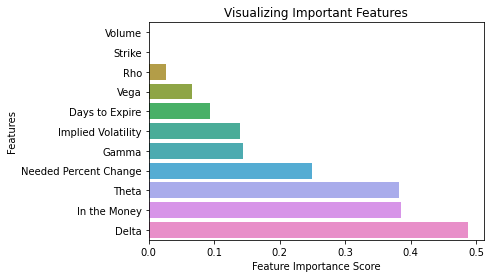

In [627]:
feature_imp = run_log_reg_model(calls_df_bs.columns.drop(["Final Price","Success", "Mark", "Breakeven Price", "Current Price"]), calls_df_bs, options7call_df_bs, False, True)

# Creating a bar plot
sns.barplot(y="Feature", x="Abs of Coefficients", data=feature_imp, orient="h", order=feature_imp.sort_values('Abs of Coefficients').Feature)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# LR Calls Model w/ Black Scholes

In [628]:
run_log_reg_model(['Needed Percent Change', 'In the Money', 'Days to Expire', 'Implied Volatility', 'Theta', 'Delta'], calls_df_bs, options7call_df_bs, False, True, True)
run_log_reg_model(['Needed Percent Change', 'Days to Expire', 'Theta', 'Delta'], calls_df_bs, options7call_df_bs, False, True, True)
run_log_reg_model(['Needed Percent Change', 'Implied Volatility', 'Theta', 'Delta'], calls_df_bs, options7call_df_bs, False, True, True)
run_log_reg_model(['Needed Percent Change', 'Volume', 'Theta', 'Delta'], calls_df_bs, options7call_df_bs, False, True, True)


,Metric:,Results:
0,Precision,0.712812
1,Recall,0.782227
2,F1,0.705812
3,Accuracy,0.729980
4,Profitability,-7260.420000
5,Profit Percent,-14.913841


,Metric:,Results:
0,Precision,0.715181
1,Recall,0.785156
2,F1,0.709091
3,Accuracy,0.733398
4,Profitability,-7094.130000
5,Profit Percent,-14.573544


,Metric:,Results:
0,Precision,0.751860
1,Recall,0.820312
2,F1,0.763766
3,Accuracy,0.793945
4,Profitability,-1625.615000
5,Profit Percent,-3.583384


,Metric:,Results:
0,Precision,0.740503
1,Recall,0.811198
2,F1,0.747919
3,Accuracy,0.776367
4,Profitability,-2280.970000
5,Profit Percent,-5.033644


,Feature,Abs of Coefficients
0,Needed Percent Change,0.235389
1,Volume,0.000004
2,Theta,0.002801
3,Delta,0.473654


# Visualizing Puts Features

,Metric:,Results:
0,Precision,0.831273
1,Recall,0.836870
2,F1,0.812428
3,Accuracy,0.812549


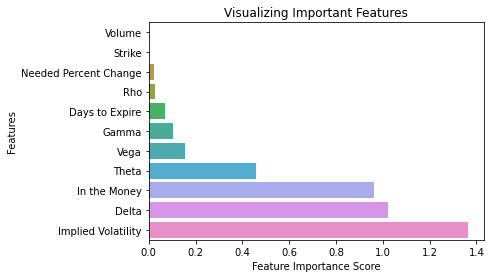

In [629]:
feature_imp = run_log_reg_model(puts_df_bs.columns.drop(["Final Price","Success", "Mark", "Breakeven Price", "Current Price"]), puts_df_bs, options7put_df_bs, False, True)

# Creating a bar plot
sns.barplot(y="Feature", x="Abs of Coefficients", data=feature_imp, orient="h", order=feature_imp.sort_values('Abs of Coefficients').Feature)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# LR Puts Model w/ Black Scholes

In [634]:
run_log_reg_model(['Needed Percent Change','In the Money', 'Implied Volatility', 'Vega', 'Rho', 'Gamma', 'Theta', 'Delta'], puts_df_bs, options7put_df_bs, False, False, True)
run_log_reg_model(['Needed Percent Change', 'Implied Volatility', 'Vega', 'Rho', 'Gamma', 'Theta', 'Delta'], puts_df_bs, options7put_df_bs, False, False, True)

,Metric:,Results:
0,Precision,0.837714
1,Recall,0.844549
2,F1,0.820944
3,Accuracy,0.821122
4,Profitability,8148.245000
5,Profit Percent,42.236842


,Metric:,Results:
0,Precision,0.840022
1,Recall,0.847684
2,F1,0.824789
3,Accuracy,0.825019
4,Profitability,8238.395000
5,Profit Percent,42.682899


,Feature,Abs of Coefficients
0,Needed Percent Change,0.016915
1,Implied Volatility,1.085406
2,Vega,2.601837
3,Rho,13.630873
4,Gamma,2.991073
5,Theta,0.292298
6,Delta,3.148362
